<h1>Predicting Ratings using Yelp User Review</h1>

<p>Each observation in this dataset is a review of a particular business by a particular user.</p>

<p>The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.</p>

<p>The "cool" column is the number of "cool" votes this review received from other Yelp users.</p>

<p>The "useful" and "funny" columns are similar to the "cool" column.</p>

<p>The goal of this project is to predict whether the customer will rate the business as GOOD, BAD or NEUTRAL</p>

<p>We have information regarding the Stars that where allocated to a business by a user. Using this we will create a new attrubute that is CUSTOMER EXP which will categorize stars 1 & 2 as BAD experience, star 3 as NEUTRAL and stars 4 % 5 as GOOD experience.</p>

<p>We will use Word clouds to obtain better infographic content of all the reviews.</p>

# Importing libraries

In [59]:
import json
import itertools
from itertools import islice

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string
import nltk
%matplotlib inline
from wordcloud.wordcloud import WordCloud, STOPWORDS
from PIL import Image
nltk.download('stopwords')

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importing the dataset

In [60]:
j_line =[]

with open('review.json', 'r',encoding = "utf8") as infile: #encoding = "utf8"
    lines_gen = islice(infile, 100000)
    for line in lines_gen:
        j_line.append(json.loads(line))
df = pd.DataFrame(j_line)

In [46]:
df.describe()

,cool,funny,stars,useful,review_len
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.547870,0.465060,3.744940,1.333570,112.886840
std,2.176363,2.348407,1.416554,5.758879,104.590151
min,0.000000,0.000000,1.000000,0.000000,1.000000
25%,0.000000,0.000000,3.000000,0.000000,44.000000
50%,0.000000,0.000000,4.000000,0.000000,80.000000
75%,1.000000,0.000000,5.000000,2.000000,145.000000
max,245.000000,447.000000,5.000000,1456.000000,1051.000000


# Feature Engineering: Cascading user ratings into categories

<p>We add a user rating column where we categorize the Stars/ratings given by users to different business as BAD, NEUTRAL and GOOD.</p>

<p>Also, we new a feature text length that gives the length of the reviews. This feature will help us understand the amount of information a user dispells while talking about the experience he has had with the business.</p>

In [61]:
user_rat = []
for i in df['stars']:
    if (i == 1):
        user_rat.append('BAD')
    elif (i == 3) or (i == 2):
        user_rat.append('NEUTRAL')
    else:
        user_rat.append('GOOD')
df['user_rat_cat'] = user_rat
df['user_rat_cat'].value_counts()
df['review_len'] = df['text'].apply(lambda x:len(x.split()))
df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,user_rat_cat,review_len
0,0W4lkclzZThpx3V65bVgig,0,2016-05-28,0,v0i_UHJMo_hPBq9bxWvW4w,5,"Love the staff, love the meat, love the place....",0,bv2nCi5Qv5vroFiqKGopiw,GOOD,56
1,AEx2SYEUJmTxVVB18LlCwA,0,2016-05-28,0,vkVSCC7xljjrAI4UGfnKEQ,5,Super simple place but amazing nonetheless. It...,0,bv2nCi5Qv5vroFiqKGopiw,GOOD,35
2,VR6GpWIda3SfvPC-lg9H3w,0,2016-05-28,0,n6QzIUObkYshz4dz2QRJTw,5,Small unassuming place that changes their menu...,0,bv2nCi5Qv5vroFiqKGopiw,GOOD,91
3,CKC0-MOWMqoeWf6s-szl8g,0,2016-05-28,0,MV3CcKScW05u5LVfF6ok0g,5,Lester's is located in a beautiful neighborhoo...,0,bv2nCi5Qv5vroFiqKGopiw,GOOD,67
4,ACFtxLv8pGrrxMm6EgjreA,0,2016-05-28,0,IXvOzsEMYtiJI0CARmj77Q,4,Love coming here. Yes the place always needs t...,0,bv2nCi5Qv5vroFiqKGopiw,GOOD,101


#  Exploratory Data Analysis

user_rat_cat
BAD        198.173913
GOOD       153.156863
NEUTRAL    193.002703
Name: review_len, dtype: float64

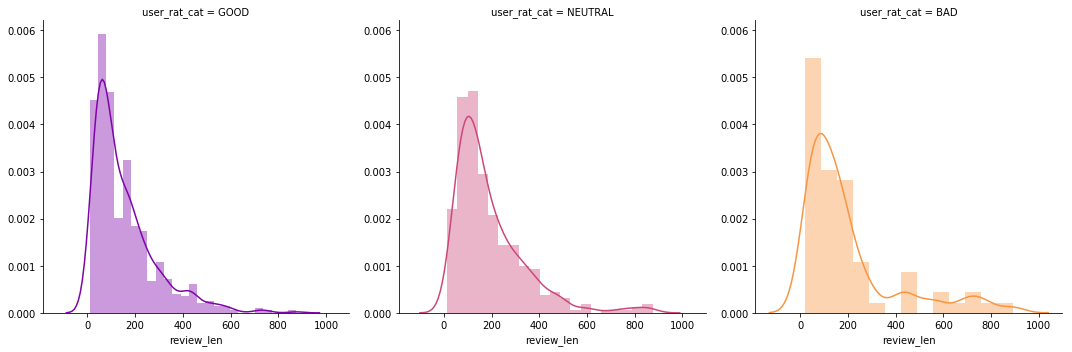

In [62]:
a = sns.FacetGrid(data = df, col = 'user_rat_cat', hue = 'user_rat_cat', palette='plasma', size=5)
a.map(sns.distplot, "review_len")
df.groupby('user_rat_cat').mean()['review_len']

<p>From the above graph we find the Density distributions and Histograms of the Text lengths for Reviews that where marked as GOOD, BAD and NEUTRAL. We observe that people who tend to review a business as BAD or NEUTRAL have approximately 150 words in their reviews while people who are suppposed to review the business as a GOOD experience have on average about 100 words in their reviews.</p>

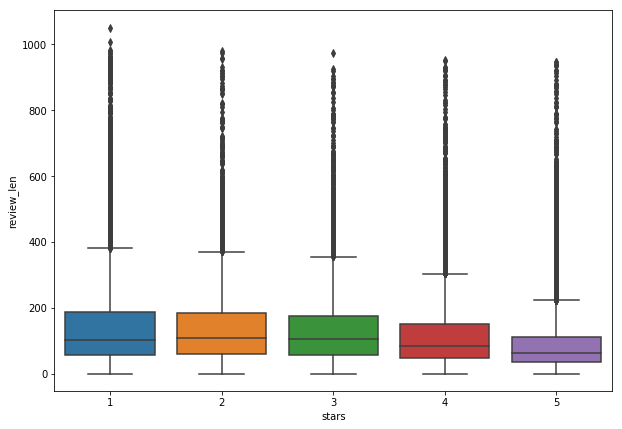

In [49]:
plt.figure(figsize = (10,7))
sns.boxplot(x = 'stars', y = 'review_len', data = df)

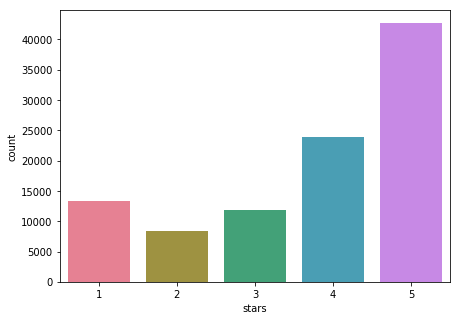

In [50]:
plt.figure(figsize = (7,5))
sns.countplot('stars', data = df, palette="husl")

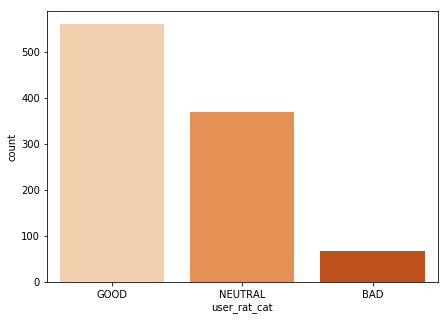

In [63]:
plt.figure(figsize = (7,5))
sns.countplot('user_rat_cat', data = df, palette="Oranges")

In [53]:
df.groupby('user_rat_cat').mean().corr()

,cool,funny,stars,useful,review_len
cool,1.000000,-0.991495,0.988084,-0.967227,-0.910534
funny,-0.991495,1.000000,-0.999712,0.925955,0.956596
stars,0.988084,-0.999712,1.000000,-0.916620,-0.963318
useful,-0.967227,0.925955,-0.916620,1.000000,0.775717
review_len,-0.910534,0.956596,-0.963318,0.775717,1.000000


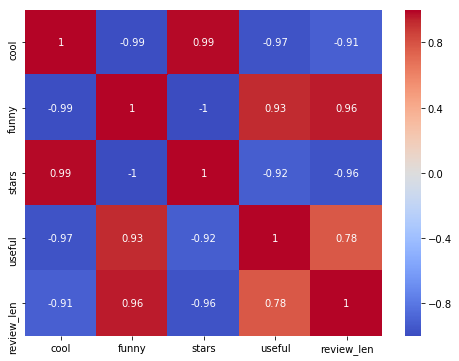

In [55]:
plt.figure(figsize = (8,6))
sns.heatmap(df.groupby('user_rat_cat').mean().corr(), cmap = "coolwarm", annot=True)

# Predicting rating category based on review

In [14]:
def text_clean(message):
    nopunc = [i for i in message if i not in string.punctuation]
    nn = "".join(nopunc)
    nn = nn.lower().split()
    nostop = [words for words in nn if words not in stopwords.words('english')]
    return(nostop)

In [78]:
good_df = df[df['user_rat_cat'] == 'GOOD']
bad_df = df[df['user_rat_cat'] == 'BAD']
neu_df = df[df['user_rat_cat'] == 'NEUTRAL']

In [79]:
good_bow = text_clean(good_df['text'])

In [80]:
bad_bow = text_clean(bad_df['text'])

In [81]:
neu_bow = text_clean(neu_df['text'])

In [102]:
good_para = ' '.join(good_bow)
bad_para = ' '.join(bad_bow)
new_para = ' '.join(neu_bow)

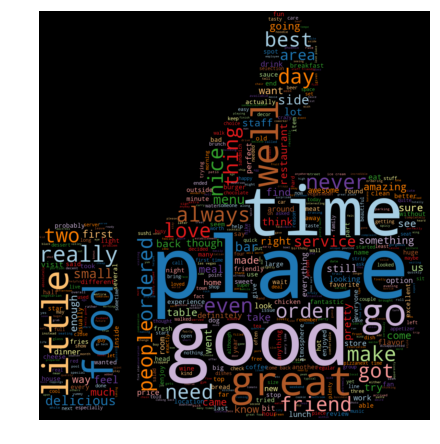

In [117]:
stopwords = set(STOPWORDS)
stopwords.add('one')
stopwords.add('also')
mask_image = np.array(Image.open("thumb_up.png"))
wordcloud_good = WordCloud(colormap = "Paired",mask = mask_image, width = 300, height = 200, scale=2,max_words=1000, stopwords=stopwords).generate(good_para)
plt.figure(figsize = (7,10))
plt.imshow(wordcloud_good, interpolation="bilinear", cmap = plt.cm.autumn)
plt.axis('off')
plt.figure(figsize = (10,6))
plt.show()
wordcloud_good.to_file("good2.png")

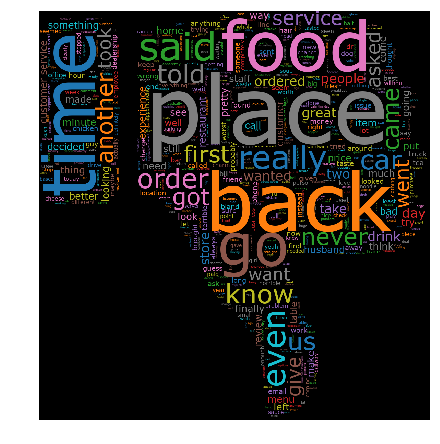

In [131]:
stopwords = set(STOPWORDS)
stopwords.add('one')
stopwords.add('also')
stopwords.add('good')
mask_image1 = np.array(Image.open("thumb_down.png"))
wordcloud_bad = WordCloud(colormap = 'tab10', mask = mask_image1, 
                          font_path = "C:\Windows\Fonts\Verdana.ttf", width = 1100, height = 700, scale=2,max_words=1000, stopwords=stopwords).generate(bad_para)
plt.figure(figsize = (7,10))
plt.imshow(wordcloud_bad,cmap = plt.cm.autumn)
plt.axis('off')
plt.show()
wordcloud_bad.to_file('bad.png')

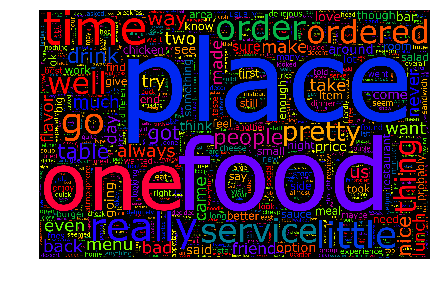

In [133]:
stopwords = set(STOPWORDS)
stopwords.add('good')
stopwords.add('great')
wordcloud_neu = WordCloud(colormap = "prism",font_path = "C:\Windows\Fonts\Verdana.ttf", width = 1100, height = 700, scale=2,max_words=1000, stopwords=stopwords).generate(new_para)
plt.figure(figsize = (7,10))
plt.imshow(wordcloud_neu,cmap = plt.cm.autumn)
plt.axis('off')
plt.show()
wordcloud_neu.to_file('neu.png')

In [64]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [65]:
cv_transformer = CountVectorizer(analyzer = text_clean)

In [66]:
x = df['text']
y = df['user_rat_cat']
x = cv_transformer.fit_transform(x)

In [106]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y,test_size = 0.3, random_state= 100)
targetnames = ["BAD","NEUTRAL","GOOD"]
kfold = 10

In [ ]:
c = [0.001, 0.1, 1, 10]
g = [0.001, 0.1, 1, 10]
bestAccuracy = 0
length = len(c)
for i in range(0, length):
    SVMModel = SVC(kernel='linear', gamma=g[i], C=c[i])
    scores = cross_val_score(SVMModel, X_train, Y_train, cv=kfold)
    score = np.mean(scores)
    if score > bestAccuracy:
        bestAccuracy = score
        bestParameter = c[i]
        bestGama = g[i]
BestSVMModel = SVC(kernel='linear', gamma=bestGama, C=bestParameter).fit(X_train, Y_train)
test_score = BestSVMModel.score(X_test,Y_test)
prediction = BestSVMModel.predict(X_test) 
print("The best accuracy using 10-fold cross validation is ", bestAccuracy)
print("The best C value using 10-fold cross validation is ", bestParameter)
print("The best Gama value using 10-fold cross validation is ", bestGama)
print("The accuracy of the final SVC model with linear kernel is ", test_score)
confusion=confusion_matrix(Y_test,prediction)
plt.figure()
plot_confusion_matrix(confusion, classes=targetnames,title='Confusion matrix')
plt.show()
print("The precision is ", precision_score(Y_test,prediction,average=None))
print("The recall is ", recall_score(Y_test,prediction,average=None))
print("The classification report divided by class is as below: ")
print(classification_report(Y_test, prediction))

In [ ]:
c = [0.001, 0.1, 1, 10]
g = [0.001, 0.1, 1, 10]
bestAccuracy = 0
length = len(c)
for i in range(0, length):
    SVMModel = SVC(kernel='rbf', gamma=g[i], C=c[i])
    scores = cross_val_score(SVMModel, X_train, Y_train, cv=kfold)
    score = np.mean(scores)
    if score > bestAccuracy:
        bestAccuracy = score
        bestParameter = c[i]
        bestGama = g[i]
BestSVMModel = SVC(kernel='rbf', gamma=bestGama, C=bestParameter).fit(X_train, Y_train)
test_score = BestSVMModel.score(X_test,Y_test)
prediction = BestSVMModel.predict(X_test) 
print("The best accuracy using 10-fold cross validation is ", bestAccuracy)
print("The best C value using 10-fold cross validation is ", bestParameter)
print("The best Gama value using 10-fold cross validation is ", bestGama)
print("The accuracy of the final SVC model with RBF kernel is ", test_score)
confusion=confusion_matrix(Y_test,prediction)
plt.figure()
plot_confusion_matrix(confusion, classes=targetnames,title='Confusion matrix')
plt.show()
print("The precision is ", precision_score(Y_test,prediction,average=None))
print("The recall is ", recall_score(Y_test,prediction,average=None))
print("The classification report divided by class is as below: ")
print(classification_report(Y_test, prediction))

In [ ]:
c = [0.001,0.01,1,10] 
penalty = ["l1", "l2"]
bestAccuracy = 0
length = len(c)
for i in range(0, length):
    for j in range(0, 2):
        LRModel =  LogisticRegression(C=c[i],penalty=penalty[j]) 
        scores = cross_val_score(LRModel, X_train, Y_train, cv=kfold)
        score = np.mean(scores)
        if score > bestAccuracy:
            bestAccuracy = score
            bestParameter = c[i]
            bestPenalty = penalty[j]
FinalLRModel = LogisticRegression(penalty=bestPenalty,C=bestParameter).fit(X_train, Y_train)
test_score = FinalLRModel.score(X_test,Y_test)
prediction = FinalLRModel.predict(X_test)
print("The best Accuracy using 10-fold cross validation is ", bestAccuracy)
print("The best C value using 10-fold cross validation is ", bestParameter)
print("The best Gama value using 10-fold cross validation is ", bestPenalty)
print("The accuracy of the final logistic regression model is ", test_score)
confusion=confusion_matrix(Y_test,prediction)
plt.figure()
plot_confusion_matrix(confusion, classes=targetnames,title='Confusion matrix')
plt.show()
print("The precision is ", precision_score(Y_test,prediction,average=None))
print("The recall is ", recall_score(Y_test,prediction,average=None))
print("The classification report divided by class is as below: ")
print(classification_report(Y_test, prediction))

The best Accuracy using 10-fold cross validation is  0.794928574192
The best Aplha value using 10-fold cross validation is  1
The accuracy of the final Naive Bayes model is  0.796233333333


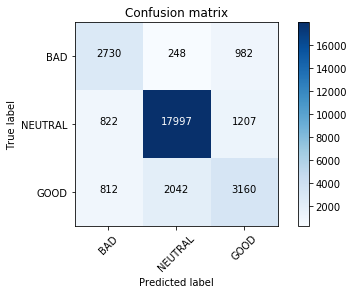

The precision is  [ 0.62557287  0.88711983  0.59076463]
The recall is  [ 0.68939394  0.89868171  0.52544064]

 The classification report divided by class is as below:  

             precision    recall  f1-score   support

        BAD       0.63      0.69      0.66      3960
       GOOD       0.89      0.90      0.89     20026
    NEUTRAL       0.59      0.53      0.56      6014

avg / total       0.79      0.80      0.79     30000



In [108]:
c = [0.001,0.01,1] 
bestAccuracy = 0
length = len(c)
for i in range(0, length):
    NBModel = MultinomialNB(alpha = c[i])
    scores = cross_val_score(NBModel, X_train, Y_train, cv=kfold)
    score = np.mean(scores)
    if score > bestAccuracy:
        bestAccuracy = score
        bestParameter = c[i]
FinalNBModel = MultinomialNB(alpha = bestParameter).fit(X_train, Y_train)
test_score = FinalNBModel.score(X_test,Y_test)
prediction = FinalNBModel.predict(X_test)
print("The best Accuracy using 10-fold cross validation is ", bestAccuracy)
print("The best Aplha value using 10-fold cross validation is ", bestParameter)
print("The accuracy of the final Naive Bayes model is ", test_score)
confusion=confusion_matrix(Y_test,prediction)
plt.figure()
plot_confusion_matrix(confusion, classes=targetnames,title='Confusion matrix')
plt.show()
print("The precision is ", precision_score(Y_test,prediction,average=None))
print("The recall is ", recall_score(Y_test,prediction,average=None))
print("\n","The classification report divided by class is as below: ","\n")
print(classification_report(Y_test, prediction))

The best Accuracy using 10-fold cross validation is  0.732371414041
The best criterion value using 10-fold cross validation is  gini
The accuracy of the final Random Forest model is  0.732733333333


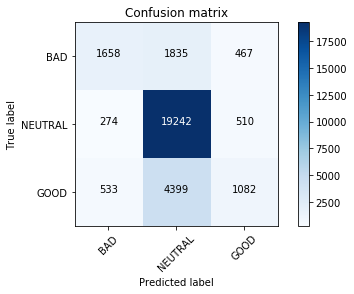

The precision is  [ 0.67261663  0.75529911  0.52549781]
The recall is  [ 0.41868687  0.96085089  0.17991354]
The classification report divided by class is as below: 
             precision    recall  f1-score   support

        BAD       0.67      0.42      0.52      3960
       GOOD       0.76      0.96      0.85     20026
    NEUTRAL       0.53      0.18      0.27      6014

avg / total       0.70      0.73      0.69     30000



In [107]:
c = ['gini',"entropy"]
bestAccuracy = 0
length = len(c)
for i in range(0, length):
    RFModel = RandomForestClassifier(criterion= c[i])
    scores = cross_val_score(RFModel, X_train, Y_train, cv=kfold)
    score = np.mean(scores)
    if score > bestAccuracy:
        bestAccuracy = score
        bestParameter = c[i]
FinalRFModel = RandomForestClassifier(criterion= bestParameter).fit(X_train, Y_train)
test_score = FinalRFModel.score(X_test,Y_test)
prediction = FinalRFModel.predict(X_test)
print("The best Accuracy using 10-fold cross validation is ", bestAccuracy)
print("The best criterion value using 10-fold cross validation is ", bestParameter)
print("The accuracy of the final Random Forest model is ", test_score)
confusion=confusion_matrix(Y_test,prediction)
plt.figure()
plot_confusion_matrix(confusion, classes=targetnames,title='Confusion matrix')
plt.show()
print("The precision is ", precision_score(Y_test,prediction,average=None))
print("The recall is ", recall_score(Y_test,prediction,average=None))
print("The classification report divided by class is as below: ")
print(classification_report(Y_test, prediction))